# Simulate mock observations data for fitting

Here we are simulating mock data to be used for fitting in later tutorials.

## Imports

In [1]:
from phitter import observables, filters
from phitter.params import star_params, binary_params, isoc_interp_params
from phitter.calc import model_obs_calc, phot_adj_calc, rv_adj_calc

import numpy as np

from phoebe import u
from phoebe import c as const
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

# The following warning regarding extinction originates from SPISEA and can be ignored.
# The functionality being warned about is not used by SPISEA.

/Users/abhimat/Software/miniforge3/envs/phoebe_py38/lib/python3.8/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Volumes/Noh/models/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


## Simulate some observations

Let's generate some mock observations from a hypothetical red giant binary system located close to the Galactic center (similar to the examples in the [previous set of tutorials](add_rv_effects)).

In [2]:
filter_153m = filters.hst_f153m_filt()
filter_127m = filters.hst_f127m_filt()

In [3]:
# Object for interpolating stellar parameters from an isochrone

isoc_stellar_params_obj = isoc_interp_params.isoc_mist_stellar_params(
    age=8e9,
    met=0.0,
    use_atm_func='merged',
    phase='RGB',
    ext_Ks=2.2,
    dist=8e3*u.pc,
    filts_list=[filter_153m, filter_127m],
    ext_law='NL18',
)

In [4]:
# Star and binary parameters

star1_params = isoc_stellar_params_obj.interp_star_params_rad(15)
star2_params = isoc_stellar_params_obj.interp_star_params_rad(12)

bin_params = binary_params.binary_params(
    period = 25.0 * u.d,
    ecc = 0.0,
    inc = 75.0 * u.deg,
    t0 = 53_800.0,
)

In [32]:
# Set up model times
# Model times are in MJD here
obs_phases_153m = np.sort(np.random.rand(25))
obs_times_153m = obs_phases_153m * bin_params.period.value + bin_params.t0

obs_phases_127m = np.sort(np.random.rand(25))
obs_times_127m = obs_phases_127m * bin_params.period.value + bin_params.t0

obs_phases_rv = np.sort(np.random.rand(5))
obs_times_rv = obs_phases_rv * bin_params.period.value + bin_params.t0

In [33]:
# Set up filter and observation type arrays for the model fluxes and RVs

obs_flux_153m_filt_arr = np.full(len(obs_phases_153m), filter_153m)
obs_flux_153m_type_arr = np.full(len(obs_phases_153m), 'phot')

obs_flux_127m_filt_arr = np.full(len(obs_phases_127m), filter_127m)
obs_flux_127m_type_arr = np.full(len(obs_phases_127m), 'phot')

obs_rv_pri_filt_arr = np.full(len(obs_phases_rv), filter_153m)
obs_rv_pri_type_arr = np.full(len(obs_phases_rv), 'rv_pri')

obs_rv_sec_filt_arr = np.full(len(obs_phases_rv), filter_153m)
obs_rv_sec_type_arr = np.full(len(obs_phases_rv), 'rv_sec')

In [34]:
# Now make arrays for all the times, filters, and observation types by concatenating the above arrays

obs_times = np.concatenate(
    (obs_times_153m, obs_times_127m, obs_times_rv, obs_times_rv),
)
obs_filts = np.concatenate(
    (obs_flux_153m_filt_arr, obs_flux_127m_filt_arr, obs_rv_pri_filt_arr, obs_rv_sec_filt_arr,),
)
obs_types = np.concatenate(
    (obs_flux_153m_type_arr, obs_flux_127m_type_arr, obs_rv_pri_type_arr, obs_rv_sec_type_arr,),
)

# Construct the observables object

model_observables = observables.observables(
    obs_times=obs_times,
    obs_filts=obs_filts, obs_types=obs_types,
)

In [35]:
# Object to perform the computation of flux and RVs

binary_model_obj = model_obs_calc.binary_star_model_obs(
    model_observables,
    use_blackbody_atm=False,
    print_diagnostics=False,
)

In [36]:
modeled_observables = binary_model_obj.compute_obs(
    star1_params, star2_params, bin_params,
)

# Add distance modulus

modeled_observables = phot_adj_calc.apply_distance_modulus(
    modeled_observables,
    8e3*u.pc,
)

# Apply reddening from extinction

modeled_observables = phot_adj_calc.apply_extinction(
    modeled_observables,
    isoc_Ks_ext=2.2,
    ref_filt=filter_153m,
    target_ref_filt_ext=4.5,
    isoc_red_law='NL18',
    ext_alpha=2.23,
)

# Add center of mass RV

modeled_observables = rv_adj_calc.apply_com_velocity(
    modeled_observables,
    150. * u.km / u.s,
)

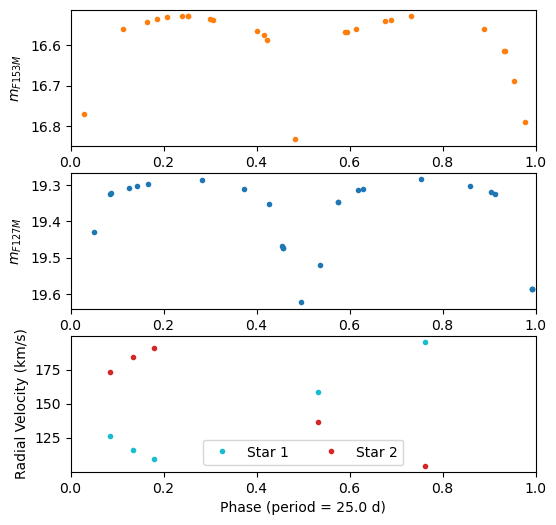

In [37]:
# Fluxes in mags
modeled_mags_153m = modeled_observables.obs[modeled_observables.phot_filt_filters[filter_153m]]
modeled_mags_127m = modeled_observables.obs[modeled_observables.phot_filt_filters[filter_127m]]

# RVs in km/s
modeled_rvs_star1 = modeled_observables.obs[modeled_observables.obs_rv_pri_filter]
modeled_rvs_star2 = modeled_observables.obs[modeled_observables.obs_rv_sec_filter]

# Draw plot
fig = plt.figure(figsize=(6,6))

# F153M mags subplot
ax_mag_153m = fig.add_subplot(3,1,1)

ax_mag_153m.plot(
    obs_phases_153m, modeled_mags_153m,
    '.', color='C1',
)

ax_mag_153m.set_xlim([0, 1])

ax_mag_153m.invert_yaxis()
ax_mag_153m.set_ylabel(r"$m_{F153M}$")

# F153M mags subplot
ax_mag_127m = fig.add_subplot(3,1,2)

ax_mag_127m.plot(
    obs_phases_127m, modeled_mags_127m,
    '.', color='C0',
)

ax_mag_127m.set_xlim([0, 1])

ax_mag_127m.invert_yaxis()
ax_mag_127m.set_ylabel(r"$m_{F127M}$")

# RVs subplot
ax_rvs = fig.add_subplot(3,1,3)

ax_rvs.plot(
    obs_phases_rv, modeled_rvs_star1,
    '.', color='C9', label='Star 1',
)

ax_rvs.plot(
    obs_phases_rv, modeled_rvs_star2,
    '.', color='C3', label='Star 2',
)

ax_rvs.set_xlabel(f"Phase (period = {bin_params.period:.1f})")
ax_rvs.set_xlim([0, 1])

ax_rvs.set_ylabel("Radial Velocity (km/s)")

ax_rvs.legend(loc='lower center', ncol=2)


## Add observation noise to data

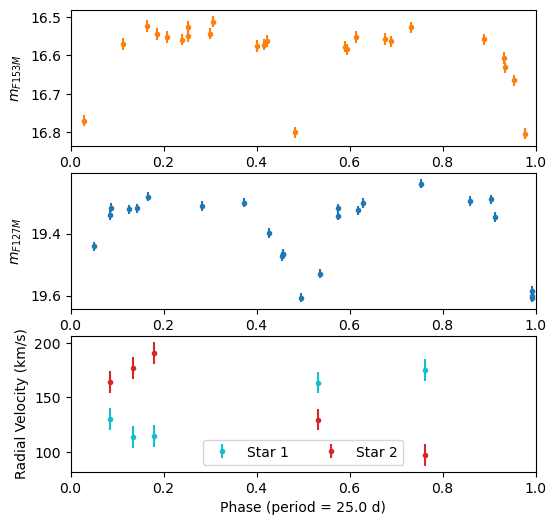

In [43]:
unc_153m = 0.015
unc_127m = 0.015
unc_rvs = 10

mock_mags_153m = modeled_mags_153m + unc_153m*np.random.randn(len(modeled_mags_153m))
mock_mags_127m = modeled_mags_127m + unc_127m*np.random.randn(len(modeled_mags_127m))

mock_mag_uncs_153m = np.full(len(mock_mags_153m), unc_153m)
mock_mag_uncs_127m = np.full(len(mock_mags_127m), unc_127m)

mock_rvs_star1 = modeled_rvs_star1 + unc_rvs*np.random.randn(len(modeled_rvs_star1))
mock_rvs_star2 = modeled_rvs_star2 + unc_rvs*np.random.randn(len(modeled_rvs_star2))

mock_rv_uncs_star1 = np.full(len(mock_rvs_star1), unc_rvs)
mock_rv_uncs_star2 = np.full(len(mock_rvs_star2), unc_rvs)

# Draw plot
fig = plt.figure(figsize=(6,6))

# F153M mags subplot
ax_mag_153m = fig.add_subplot(3,1,1)

ax_mag_153m.errorbar(
    obs_phases_153m, mock_mags_153m,
    yerr=mock_mag_uncs_153m,
    fmt='.', color='C1',
)

ax_mag_153m.set_xlim([0, 1])

ax_mag_153m.invert_yaxis()
ax_mag_153m.set_ylabel(r"$m_{F153M}$")

# F153M mags subplot
ax_mag_127m = fig.add_subplot(3,1,2)

ax_mag_127m.errorbar(
    obs_phases_127m, mock_mags_127m,
    yerr=mock_mag_uncs_127m,
    fmt='.', color='C0',
)

ax_mag_127m.set_xlim([0, 1])

ax_mag_127m.invert_yaxis()
ax_mag_127m.set_ylabel(r"$m_{F127M}$")

# RVs subplot
ax_rvs = fig.add_subplot(3,1,3)

ax_rvs.errorbar(
    obs_phases_rv, mock_rvs_star1,
    yerr=mock_rv_uncs_star1,
    fmt='.', color='C9', label='Star 1',
)

ax_rvs.errorbar(
    obs_phases_rv, mock_rvs_star2,
    yerr=mock_rv_uncs_star1,
    fmt='.', color='C3', label='Star 2',
)

ax_rvs.set_xlabel(f"Phase (period = {bin_params.period:.1f})")
ax_rvs.set_xlim([0, 1])

ax_rvs.set_ylabel("Radial Velocity (km/s)")

ax_rvs.legend(loc='lower center', ncol=2)


# Save out final mock data

In [52]:
# Save mock data

from astropy.table import Table
import pickle

obs_array = np.concatenate(
    (
        mock_mags_153m, mock_mags_127m,
        mock_rvs_star1, mock_rvs_star2,
    )
)

obs_uncs_array = np.concatenate(
    (
        mock_mag_uncs_153m, mock_mag_uncs_127m,
        mock_rv_uncs_star1, mock_rv_uncs_star2,
    )
)

obs_table = Table(
    [
        obs_times,
        obs_array,
        obs_uncs_array,
        obs_types,
        obs_filts,
    ],
    names=(
        'obs_times',
        'obs',
        'obs_uncs',
        'obs_types',
        'obs_filts',
    ),
)

print(obs_table)

obs_table.write(
    'mock_obs_data.txt', format='ascii.fixed_width',
    overwrite=True,
)

# Pickle table object
with open('mock_obs_table.pkl', 'wb') as out_pickle:
    pickle.dump(obs_table, out_pickle)

    obs_times             obs         obs_uncs obs_types                       obs_filts                       
------------------ ------------------ -------- --------- ------------------------------------------------------
53800.714762925796 16.769110541124228    0.015      phot <phitter.filters.hst_f153m_filt object at 0x105a07340>
 53802.78887450278 16.569960382011555    0.015      phot <phitter.filters.hst_f153m_filt object at 0x105a07340>
 53804.08607971392 16.523859319835843    0.015      phot <phitter.filters.hst_f153m_filt object at 0x105a07340>
 53804.64136070461  16.54425287095397    0.015      phot <phitter.filters.hst_f153m_filt object at 0x105a07340>
53805.203583377115 16.551835703948942    0.015      phot <phitter.filters.hst_f153m_filt object at 0x105a07340>
 53805.96328097839 16.559083907180494    0.015      phot <phitter.filters.hst_f153m_filt object at 0x105a07340>
53806.315847597616 16.526208341236522    0.015      phot <phitter.filters.hst_f153m_filt object at 0x105